#### Frame the hypothesis first

1. Win–rate question – does a lower latency still translate into more wins?

2. Profit question – does it still translate into higher cumulative profit?



## 1 . Extract the auction result dataset

- cutoff_time	the auction’s deadline for the round
- strategies	for each player id: (strategy_code, bid_amount, submit_time)
- valuations	each player’s private value for the block
- winner	(player_id, winning_bid, profit)

In [1]:
#------------------------------------------------------
# Imports & config
#------------------------------------------------------

import random
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from player import ReactiveGaussianRangePlayer, GaussianRangePlayer

from auction import Auction
from player_setup import generate_players
import player

# Same parameter block that main.py uses
num_players                     = 10
num_reactive                    = 5

gaussian_speed_min_range        = (0.0, 0.2)
gaussian_speed_max_range        = (0.2, 0.6)
gaussian_bid_prop_mean_range    = (0.75, 0.95)
gaussian_bid_prop_std_range     = (0.3, 0.5)

reactive_speed_min_range        = (0.3, 0.5)
reactive_speed_max_range        = (0.6, 0.9)
reactive_bid_prop_mean_range    = (0.85, 0.95)
reactive_bid_prop_std_range     = (0.2, 0.4)
reactive_others_mean_range      = gaussian_bid_prop_mean_range
reactive_others_std_range       = gaussian_bid_prop_std_range

cutoff_time_range               = (0.9, 1.0)
num_rounds = 100_000 
random.seed(14)

In [2]:
#------------------------------------------------------
# Generate players & run the simulation
#------------------------------------------------------
# Build the player list
players = generate_players(
    num_players,
    num_reactive,
    gaussian_speed_min_range,
    gaussian_speed_max_range,
    gaussian_bid_prop_mean_range,
    gaussian_bid_prop_std_range,
    reactive_speed_min_range,
    reactive_speed_max_range,
    reactive_bid_prop_mean_range,
    reactive_bid_prop_std_range,
    reactive_others_mean_range,
    reactive_others_std_range
)

# Run the auction
auction = Auction(players, cutoff_time_range=cutoff_time_range)
round_results, player_winnings = auction.run_simulation(num_rounds)
print(f"Completed {len(round_results):,} rounds")

Completed 100,000 rounds


In [3]:
#------------------------------------------------------
# Flatten every (round, player) into one tidy row
#------------------------------------------------------

rows = []
for rnd, rd in enumerate(round_results):
    cutoff = rd["cutoff_time"]
    winner_id, winning_bid, winning_value = (rd["winner"] or (None, None, 0.0))
    
    for p in players:
        strat_code, bid_prop, submit_time = rd["strategies"][p.player_id]
        rows.append({
            "round":        rnd,
            "player_id":    p.player_id,
            "reactive":     isinstance(p, player.ReactiveGaussianRangePlayer),
            "speed_min":    p.speed[0],
            "speed_max":    p.speed[1],
            "submit_time":  submit_time,
            "cutoff_time":  cutoff,
            "valuation":    rd["valuations"][p.player_id],
            "bid_prop":     bid_prop,
            "bid_amount":   p.val * bid_prop,       
            "won":          int(p.player_id == winner_id),
            "profit":       winning_value if p.player_id == winner_id else 0.0
        })

df = pd.DataFrame(rows)
print(df.shape)
df.head()

(1000000, 12)


,round,player_id,reactive,speed_min,speed_max,submit_time,cutoff_time,valuation,bid_prop,bid_amount,won,profit
0,0,1,False,0.131690,0.321195,0.221614,0.959545,0.236263,0.081909,0.071338,0,0.0
1,0,6,True,0.340884,0.893400,0.819061,0.959545,0.423110,0.236027,0.109198,0,0.0
2,0,8,False,0.155503,0.247360,0.161607,0.959545,0.263539,0.326887,0.073042,0,0.0
3,0,5,False,0.130340,0.249211,0.213962,0.959545,0.704894,0.085026,0.048105,0,0.0
4,0,7,True,0.318934,0.862438,0.329319,0.959545,0.569402,0.570876,0.309235,0,0.0


In [4]:
df['bid_amount'].describe()
# df['profit'].describe()

count    1000000.000000
mean           0.237993
std            0.171919
min            0.000001
25%            0.096606
50%            0.207363
75%            0.348416
max            0.870075
Name: bid_amount, dtype: float64

In [5]:
df.to_csv("auction_rounds.csv", index=False)

## 2 . Quick exploratory checks (sanity)
- Distribution of *submit_time* vs *cutoff_time*
   
    Histogram ensures players really submit across the whole window.

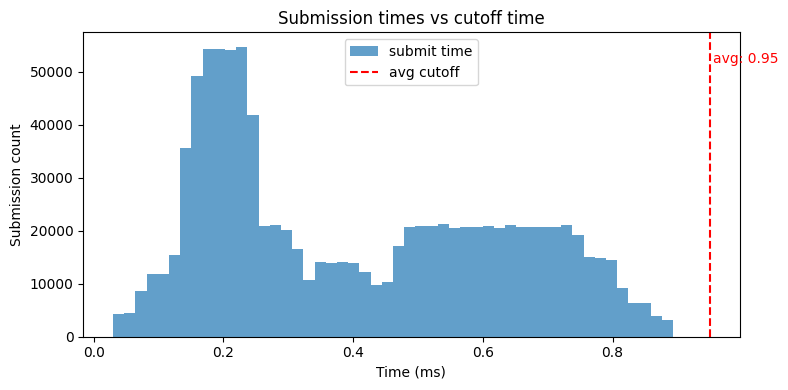

In [6]:

# Distribution of Submit Times vs Cutoff Time
# What it shows: Are builders submitting across the whole cutoff window?

avg_cutoff = df["cutoff_time"].mean()

plt.figure(figsize=(8, 4))
plt.hist(df["submit_time"], bins=50, alpha=0.7, label="submit time")
plt.axvline(avg_cutoff, color="red", linestyle="--", label="avg cutoff")
plt.text(avg_cutoff + 0.005, plt.ylim()[1]*0.9, f"avg: {avg_cutoff:.3}", color="red")
plt.xlabel("Time (ms)")
plt.ylabel("Submission count")
plt.title("Submission times vs cutoff time")
plt.legend()
plt.tight_layout()
plt.show()

Submission times are well distributed up to the cutoff, and players are submitting across the whole window, not clustering tightly.

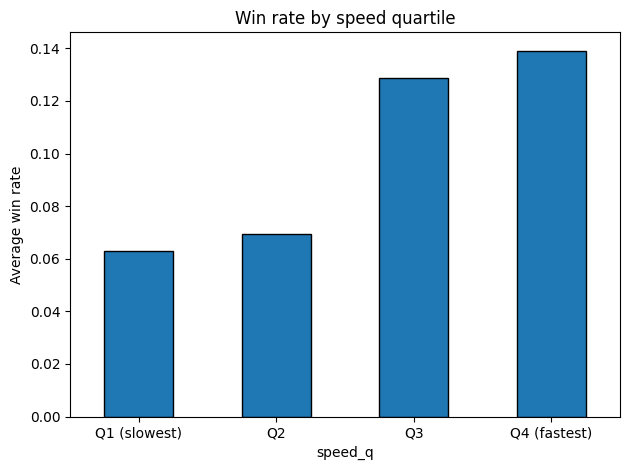

In [7]:
# Win Rate by Speed Quartile
# What it shows: Does being faster still help players win more?

# Group speed_max into 4 buckets
df["speed_q"] = pd.qcut(df["submit_time"], 4, labels=["Q1 (slowest)", "Q2", "Q3", "Q4 (fastest)"])

# Average win rate per speed quartile
win_rate_by_q = df.groupby("speed_q")["won"].mean()

win_rate_by_q.plot(kind="bar", edgecolor="black")
plt.ylabel("Average win rate")
plt.title("Win rate by speed quartile")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Win rates are fairly flat, but slightly higher in Q3 and Q4. This might suggest faster players win a little more, but it's not dramatic

## 3 . Metrics to answer the speed question

1. Win-rate by speed quartile	df.groupby(speed_q)["won"].mean()	Flat line ⇒ no timing edge
2. Profit by speed quartile	df.groupby(speed_q)["profit"].sum()	Same story for profits
3. Correlation: speed_max vs win	df[["speed_max","won"]].corr()	Pearson close to 0 is good
4. Logistic regression: won ~ speed_max + reactive	statsmodels	Controls for strategy type

Create speed_q = pd.qcut(df["speed_max"], 4, labels=False)

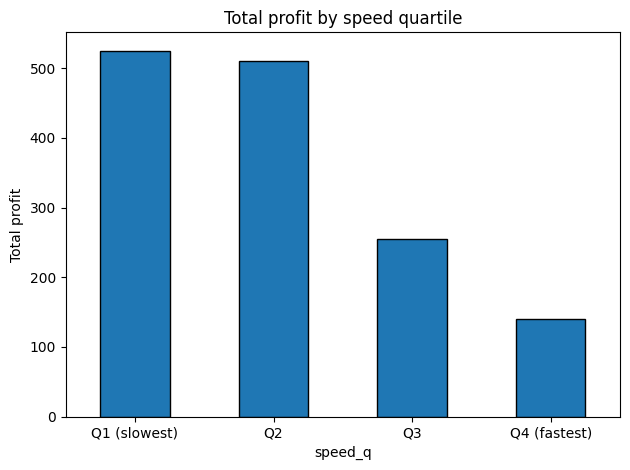

In [8]:
# Total Profit by Speed Quartile
# What it shows: Do faster builders end up earning more profit?

profit_by_q = df.groupby("speed_q")["profit"].sum()

profit_by_q.plot(kind="bar", edgecolor="black")
plt.ylabel("Total profit")
plt.title("Total profit by speed quartile")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

This is an evidence that speed alone isn't a clean advantage. If faster always mean richer, Q4 would dominate — but Q3 outperforms Q4, and even Q1 nearly matches Q3.

## 4 . Visualisations

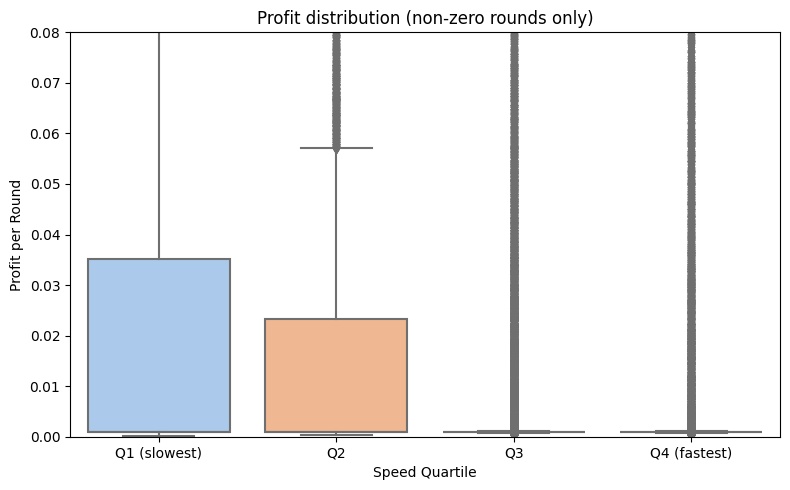

In [9]:
# Profit per Round by Speed Quartile

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df[df["profit"] > 0], x="speed_q", y="profit", palette="pastel")
#ns.boxplot(data=df, x="speed_q", y="profit", palette="pastel")

plt.xlabel("Speed Quartile")
plt.ylabel("Profit per Round")
plt.title("Profit distribution (non-zero rounds only)")
#plt.yscale('log')
plt.ylim(0, 0.08)
plt.tight_layout()
plt.show()

As long as speed doesn’t determine who wins more often, it won’t affect profit at all — because when someone does win, their profit comes from the same underlying distribution.